## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Handle Price Outliers](#4.5_Handle_Price_Outliers)
  * [4.6 Train/Test Split](#4.6_Train/Test_Split)
  * [4.7 Linear Regression Model](#4.7_Linear_Regression_Model)
  * [4.8 Random Forest Model](#4.8_Random_Forest_Model)
      * [4.8.1 Feature Selection](#4.8.1_Feature_Selection)
  * [4.9 Gradient Boosting Model](#4.9_Gradient_Boosting_Model)
  * [4.10 XGBoost Model](#4.10_XGBoost_Model)
    * [4.10.1 Hyperparameter search using GridSearchCV](#4.10.1_Hyperparameter_search_using_GridSearchCV)
  * [4.11 Final Model Selection](#4.11_Final_Model_Selection)
  * [4.12 Save Best Model and Train/Test_Files](#4.12_Save_Best_Model_and_Train/Test_Files)

# 4.2 Introduction<a id='4.2_Introduction'></a>

# 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
import numpy as np
import statsmodels.api as sm # Has various stats models for modeling data.
from statsmodels.graphics.api import abline_plot # Has graphical features.
from sklearn.metrics import mean_squared_error, r2_score #Calculates relevant metrics for performance.
from sklearn.model_selection import train_test_split # Can use to split the data into 2.
from sklearn import linear_model, preprocessing # For creating linear regression models
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import pickle
from xgboost import XGBRegressor

# 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
house_attr_df=pd.read_csv('../data/processed/houseattribute_df.csv')

In [6]:
house_attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084909 entries, 0 to 1084908
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   brokered_by     1084909 non-null  float64
 1   status          1084909 non-null  object 
 2   price           1084909 non-null  float64
 3   bed             1084909 non-null  float64
 4   bath            1084909 non-null  float64
 5   acre_lot        1084909 non-null  float64
 6   street          1084909 non-null  float64
 7   city            1084909 non-null  object 
 8   state           1084909 non-null  object 
 9   zip_code        1084909 non-null  float64
 10  house_size      1084909 non-null  float64
 11  prev_sold_date  1084909 non-null  object 
dtypes: float64(8), object(4)
memory usage: 99.3+ MB


In [7]:
house_attr_df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,92147.0,for_sale,110000.0,7.0,3.0,0.09,1842706.0,Dorado,Puerto Rico,949.0,1192.0,2019-06-28
1,94933.0,for_sale,950000.0,5.0,4.0,0.99,1260473.0,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11
2,103341.0,for_sale,6899000.0,4.0,6.0,0.83,17467.0,Saint Thomas,Virgin Islands,802.0,4600.0,2018-04-05
3,21163.0,for_sale,525000.0,3.0,3.0,0.45,1813270.0,Agawam,Massachusetts,1001.0,2314.0,2014-06-25
4,67455.0,for_sale,289900.0,3.0,2.0,0.36,1698080.0,Agawam,Massachusetts,1001.0,1276.0,2012-10-12


In [8]:
house_attr_df['price'].quantile(.25),house_attr_df['price'].quantile(.75)

(240000.0, 600000.0)

In [10]:
house_attr_df.shape

(1084909, 12)

(array([1.084868e+06, 3.400000e+01, 4.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.00000000e+00, 5.15000009e+07, 1.03000001e+08, 1.54500001e+08,
        2.06000001e+08, 2.57500000e+08, 3.09000000e+08, 3.60500000e+08,
        4.12000000e+08, 4.63500000e+08, 5.15000000e+08]),
 <BarContainer object of 10 artists>)

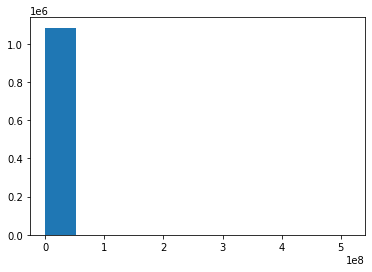

In [11]:
plt.hist(house_attr_df['price'])

(array([ 160.,  209.,  356.,  600.,  456., 1142.,  959., 1793., 1340.,
        2567.]),
 array([1.00000e+00, 5.00080e+03, 1.00006e+04, 1.50004e+04, 2.00002e+04,
        2.50000e+04, 2.99998e+04, 3.49996e+04, 3.99994e+04, 4.49992e+04,
        4.99990e+04]),
 <BarContainer object of 10 artists>)

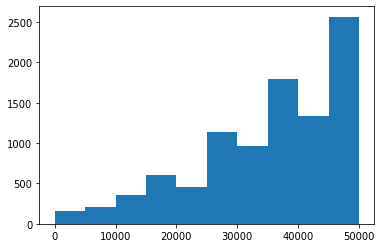

In [13]:
plt.hist(house_attr_df[house_attr_df['price']< 50000]['price'])

(array([5.286e+03, 3.000e+01, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.025000e+06, 5.602250e+07, 1.070200e+08, 1.580175e+08,
        2.090150e+08, 2.600125e+08, 3.110100e+08, 3.620075e+08,
        4.130050e+08, 4.640025e+08, 5.150000e+08]),
 <BarContainer object of 10 artists>)

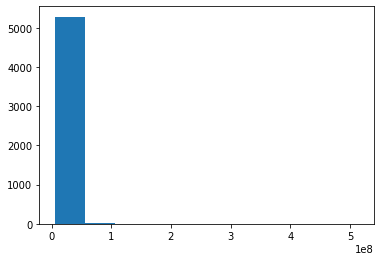

In [14]:
plt.hist(house_attr_df[house_attr_df['price']>5000000]['price'])

In [15]:
house_attr_df[house_attr_df['price']< 50000]

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
201,98460.0,for_sale,40000.0,2.0,1.0,0.29,1314092.0,Winchester,Connecticut,6098.0,1450.0,2015-03-13
301,37775.0,for_sale,24900.0,7.0,3.0,0.24,174347.0,Springfield,Massachusetts,1105.0,3727.0,2006-12-28
680,99968.0,for_sale,49999.0,4.0,2.0,0.10,662612.0,North Adams,Massachusetts,1247.0,1822.0,2000-06-12
1796,10211.0,for_sale,40000.0,2.0,1.0,0.20,1202236.0,Nassau,New York,12123.0,690.0,2005-12-01
1842,38575.0,for_sale,49900.0,2.0,1.0,0.13,179494.0,Schodack Landing,New York,12123.0,1200.0,1993-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1070087,79449.0,sold,19000.0,1.0,1.0,0.12,924638.0,Sumas,Washington,98295.0,280.0,2022-02-25
1078635,53569.0,sold,515.0,3.0,2.0,5.09,14594.0,Raymond,Washington,98577.0,3060.0,2022-04-11
1079347,83639.0,sold,49900.0,3.0,2.0,0.11,1408540.0,Longview,Washington,98632.0,924.0,2022-02-03
1080764,10515.0,sold,1695.0,3.0,4.0,1.00,247722.0,Leavenworth,Washington,98826.0,3910.0,2022-01-25


In [16]:
9582/1084909

0.008832077160388568

In [17]:
house_attr_df[house_attr_df['price']>5000000]

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
2,103341.0,for_sale,6899000.0,4.0,6.0,0.83,17467.0,Saint Thomas,Virgin Islands,802.0,4600.0,2018-04-05
467,32014.0,for_sale,15500000.0,3.0,5.0,298.00,672203.0,New Marlborough,Massachusetts,1259.0,4273.0,2011-01-28
538,108004.0,for_sale,5995000.0,4.0,5.0,115.00,1021512.0,Avon,Connecticut,6001.0,6964.0,1987-12-28
1308,80750.0,for_sale,60000000.0,9.0,10.0,400.00,1246311.0,Woodstock,Connecticut,6281.0,18777.0,2003-08-28
1811,10858.0,for_sale,12500000.0,33.0,15.0,89.00,958133.0,Lenox,Massachusetts,1240.0,20821.0,1999-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...
1069699,71365.0,sold,7900000.0,4.0,4.0,25.26,932782.0,Orcas Island,Washington,98279.0,5008.0,2021-11-22
1073137,108218.0,sold,9880000.0,6.0,6.0,0.56,1657608.0,Medina,Washington,98039.0,6470.0,2022-03-14
1074510,48710.0,sold,5600000.0,3.0,4.0,0.28,1718705.0,Gig Harbor,Washington,98332.0,5490.0,2022-05-06
1081039,108288.0,sold,12500000.0,5.0,3.0,957.26,967662.0,Ellensburg,Washington,98926.0,2849.0,2022-04-08


In [18]:
5322/1084909

0.004905480551825084

(array([5.286e+03, 3.000e+01, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([5.025000e+06, 5.602250e+07, 1.070200e+08, 1.580175e+08,
        2.090150e+08, 2.600125e+08, 3.110100e+08, 3.620075e+08,
        4.130050e+08, 4.640025e+08, 5.150000e+08]),
 <BarContainer object of 10 artists>)

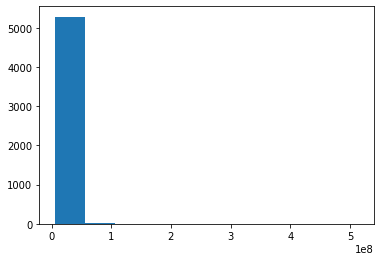

In [20]:
plt.hist(house_attr_df[house_attr_df['price']>5000000]['price'])

# 4.5 Handle Price Outliers<a id='4.5_Handle_Price_Outliers'></a>

In [3]:
house_attr_df=house_attr_df[house_attr_df['price'].between(50001,4999999,inclusive=True)]

In [24]:
house_attr_df.shape

(1069194, 12)

In [25]:
house_attr_df.columns

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [4]:
features=house_attr_df.drop(columns=['price','prev_sold_date','status'],axis=1).columns
X=house_attr_df[features]
y=house_attr_df['price']

In [60]:
X.columns

Index(['brokered_by', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state',
       'zip_code', 'house_size'],
      dtype='object')

In [61]:
y.head()

0    110000.0
1    950000.0
3    525000.0
4    289900.0
5    384900.0
Name: price, dtype: float64

# 4.6 Train/Test Split<a id='4.6_Train/Test_Split'></a>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5000)

In [28]:
X_train.columns

Index(['brokered_by', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state',
       'zip_code', 'house_size'],
      dtype='object')

Model prediction interpretation.

In [64]:
# y_train.loc[X_train[(X_train['state']=='Iowa') & (X_train['zip_code']==52235)].index].values.mean()

In [65]:
# X_train[(X_train['state']=='Georgia') & (X_train['zip_code']==30342)]

In [66]:
# X_train[(X_train['state']=='Iowa') & (X_train['zip_code']==52235)]

In [6]:
labelencoder=preprocessing.LabelEncoder()
ordencoder=preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)
colstoencode=['city']
X_train['city']=ordencoder.fit_transform(X_train[colstoencode])
X_train['state']=labelencoder.fit_transform(X_train['state'])

C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [7]:
minmaxscaler=preprocessing.MinMaxScaler()
X_train=pd.DataFrame(minmaxscaler.fit_transform(X_train),columns=X_train.columns)

In [31]:
X_train.head()

,brokered_by,bed,bath,acre_lot,street,city,state,zip_code,house_size
0,0.843793,0.014218,0.014218,0.000004,0.851570,0.978850,0.634615,0.280063,0.001718
1,0.205290,0.014218,0.009479,0.000003,0.326377,0.851739,0.576923,0.073233,0.001271
2,0.061584,0.009479,0.004739,0.000376,0.752926,0.961462,0.480769,0.656331,0.001330
3,0.483303,0.004739,0.009479,0.000005,0.075233,0.624414,0.615385,0.120323,0.000672
4,0.646865,0.014218,0.009479,0.000002,0.315950,0.707026,0.846154,0.749484,0.002034


# 4.7 Linear Regression Model<a id='4.7_Linear_Regression_Model'></a>

In [32]:
# Create the model: make a variable called rModel, and use it linear_model.LinearRegression appropriately
rModel=linear_model.LinearRegression()

In [33]:
rModel.fit(X_train,y_train)

LinearRegression()

In [34]:
y_train

97729     683785.0
509146    399000.0
293271    339000.0
516270    279000.0
830864    586000.0
            ...   
617837    269990.0
676323    310000.0
972658    699000.0
497632    564900.0
192043    245000.0
Name: price, Length: 748435, dtype: float64

In [35]:
rModel.predict(X_train)

array([713557.43265039, 467009.94234686, 483749.04189343, ...,
       841585.20233595,  65916.88662983, 269264.00161476])

In [78]:
help(rModel)

Help on LinearRegression in module sklearn.linear_model._base object:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean and dividing by the l2-norm.
 |      If you wish to standardize, please use
 |      :class:

In [36]:
rModel.coef_

array([-3.44190618e+04, -3.15969580e+05,  4.14249083e+07,  2.45271692e+04,
        5.52252329e+03,  4.22245780e+04, -2.46453646e+05,  2.97976888e+05,
        3.69328686e+07])

In [37]:
def mse(obs,pred):
    e=np.sum((obs-pred)**2)
    return e

In [38]:
def rmse(obs,pred):
    e=np.sum((obs-pred)**2)/len(obs)
    e=np.sqrt(e)
    return e

In [39]:
pred=rModel.predict(X_train)
# Put the predictions & actual values into a dataframe
obs=y_train.values
d={'Predicted':pred,'Actual':obs}
model_df=pd.DataFrame.from_dict(d)
model_df.head()
print('train rmse linear regression:'+str(rmse(model_df['Actual'],model_df['Predicted'])))
print('train r2_score linear regression:'+str(r2_score(y_train.values,pred)))
print('train MAE linear regression:'+str(mean_absolute_error(y_train.values,pred)))

train rmse linear regression:428988.48188893654
train r2_score linear regression:0.30443102719258663
train MAE linear regression:250076.27446830837


# 4.8 Random Forest Model<a id='4.8_Random_Forest_Model'></a>

In [8]:
pipe = make_pipeline( 
    SelectKBest(f_regression, k=9),
    RandomForestRegressor(n_estimators=125,max_depth=5)
)

## 4.8.1 Feature Selection<a id='4.8.1_Feature_Selection'></a>

In [9]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [10]:
rf_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(k=9,
                                                    score_func=<function f_regression at 0x000001EF6BE2B0D0>)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(max_depth=5,
                                                              n_estimators=125))]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [11]:
score_mean = rf_grid_cv.cv_results_['mean_test_score']
score_std = rf_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in rf_grid_cv.cv_results_['param_selectkbest__k']]

In [12]:
rf_grid_cv.best_params_

{'selectkbest__k': 8}

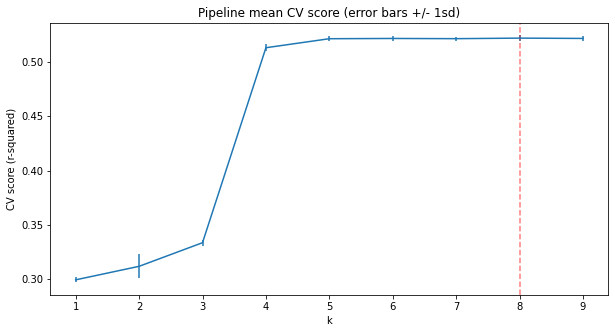

In [13]:
best_k = rf_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [14]:
selected = rf_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [15]:
coefs = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

bath           0.401169
zip_code       0.335412
house_size     0.228280
state          0.032241
bed            0.002886
city           0.000012
street         0.000000
brokered_by    0.000000
dtype: float64

[0.00000000e+00 2.88613892e-03 4.01168504e-01 0.00000000e+00
 1.21849952e-05 3.22412143e-02 3.35411777e-01 2.28280180e-01]


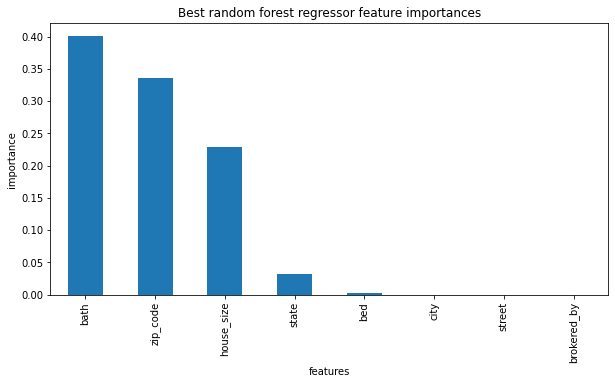

In [16]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
print(imps)
rf_feat_imps = pd.Series(imps, index=features).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [17]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [18]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
print('train mae mean and standard deviation random forest:'+str(rf_mae_mean)+','+str(rf_mae_std))

train mae mean and standard deviation random forest:200652.3016682384,984.4428259782868


In [55]:
rf=RandomForestRegressor(n_estimators=125,max_depth=5)
rf.fit(X_train[['bath','zip_code','house_size','state','bed','city']],y_train)

RandomForestRegressor(max_depth=5, n_estimators=125)

In [56]:
pred=rf.predict(X_train[['bath','zip_code','house_size','state','bed','city']])
r2_score(pred,y_train)

0.03271037122443787

In [57]:
mean_squared_error(y_train, pred, squared=False)

355520.25525846356

In [58]:
mean_absolute_error(pred,y_train)

200812.3243525022

In [59]:
X_train=X_train[['bath','zip_code','house_size','state','bed','city']]
X_test=X_test[['bath','zip_code','house_size','state','bed','city']]

# 4.9 Gradient Boosting Model<a id='4.9_Gradient_Boosting_Model'></a>

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
sklearn_gbm = GradientBoostingRegressor(
    n_estimators=150, 
    learning_rate=0.1, 
    max_depth=5
)
sklearn_gbm.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=150)

In [61]:
print('train MSE gb:'+str(mean_squared_error(y_train, sklearn_gbm.predict(X_train), squared=False)))
y_pred=sklearn_gbm.predict(X_train)
print('train r2_score gb:'+str(r2_score(y_pred,y_train)))
print('train MAE gb:'+str(mean_absolute_error(y_pred,y_train)))

train MSE gb:272683.05242138595
train r2_score gb:0.5607489649228619
train MAE gb:143216.3557416054


# 4.10 XGBoost Model<a id='4.10_XGBoost_Model'></a>

In [64]:
xgb = XGBRegressor(
    n_estimators=150, 
    learning_rate=0.1, 
    max_depth=5,
    early_stopping_rounds=10,
#     min_child_weight=3,
#     reg_alpha=.05,
#     reg_lambda=.05
#     num_parallel_tree=10
)
xgb.fit(X_train, y_train)

[10:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [65]:
print('train MSE xgb:'+str(mean_squared_error(y_train, xgb.predict(X_train), squared=False)))
y_pred=xgb.predict(X_train)
print('train r2_score xgb:'+str(r2_score(y_pred,y_train)))
print('train MAE xgb:'+str(mean_absolute_error(y_pred,y_train)))

train MSE xgb:273380.1325604451
train r2_score xgb:0.5594026766488702
train MAE xgb:143316.47576269045


In [125]:
pipe = make_pipeline( 
    XGBRegressor()
)

In [126]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'xgbregressor', 'xgbregressor__objective', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__enable_categorical', 'xgbregressor__gamma', 'xgbregressor__gpu_id', 'xgbregressor__importance_type', 'xgbregressor__interaction_constraints', 'xgbregressor__learning_rate', 'xgbregressor__max_delta_step', 'xgbregressor__max_depth', 'xgbregressor__min_child_weight', 'xgbregressor__missing', 'xgbregressor__monotone_constraints', 'xgbregressor__n_estimators', 'xgbregressor__n_jobs', 'xgbregressor__num_parallel_tree', 'xgbregressor__predictor', 'xgbregressor__random_state', 'xgbregressor__reg_alpha', 'xgbregressor__reg_lambda', 'xgbregressor__scale_pos_weight', 'xgbregressor__subsample', 'xgbregressor__tree_method', 'xgbregressor__validate_parameters', 'xgbregressor__verbosity'])

## 4.10.1 Hyperparameter search using GridSearchCV<a id='4.10.1_Hyperparameter_search_using_GridSearchCV'></a>

In [127]:
param_grid={
    'xgbregressor__n_estimators':[150,250,500],
#     'xgbregressor__learning_rate':[.01,.1],
    'xgbregressor__max_depth':[5,8,10],
#     'xgbregressor__min_child_weight':[1,2,3,4,5,6]
}

In [128]:
xgb_grid_cv = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
xgb_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                            

In [129]:
xgb_grid_cv.best_params_

{'xgbregressor__max_depth': 8, 'xgbregressor__n_estimators': 500}

In [109]:
score_mean = xgb_grid_cv.cv_results_['mean_test_score']
score_std = xgb_grid_cv.cv_results_['std_test_score']
# cv_k = [k for k in gb_grid_cv.cv_results_['param_selectkbest__k']]

In [66]:
xgb = XGBRegressor(
    n_estimators=500, 
    max_depth=8,
#     min_child_weight=3,
#     reg_alpha=.05,
#     reg_lambda=.05
#     num_parallel_tree=10
)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [67]:
print('train MSE xgb:'+str(mean_squared_error(y_train, xgb.predict(X_train), squared=False)))
y_pred=xgb.predict(X_train)
print('train r2_score xgb:'+str(r2_score(y_pred,y_train)))
print('train MAE xgb:'+str(mean_absolute_error(y_pred,y_train)))

train MSE xgb:162607.92552726937
train r2_score xgb:0.8812811636854065
train MAE xgb:91167.46937656231


# 4.11 Final Model Selection<a id='4.11_Final_Model_Selection'></a>

Reduced max depth hyperparameter from 8 to 5 to prevent overfitting. This resulted in a lower R squared on the train dataset but performed better on the test dataset so decided to proceed with the XGBoost version2 model below.

In [72]:
xgbv2 = XGBRegressor(
    n_estimators=500, 
    max_depth=5,
#     min_child_weight=3,
#     reg_alpha=.05,
#     reg_lambda=.05
#     num_parallel_tree=10
)
xgbv2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [73]:
print('train MSE xgbv2:'+str(mean_squared_error(y_train, xgbv2.predict(X_train), squared=False)))
y_pred=xgbv2.predict(X_train)
print('train r2_score xgbv2:'+str(r2_score(y_pred,y_train)))
print('train MAE xgbv2:'+str(mean_absolute_error(y_pred,y_train)))

train MSE xgbv2:212837.7911367913
train r2_score xgbv2:0.7795234054129901
train MAE xgbv2:113642.19360562338


In [74]:
pd.DataFrame({"coef":xgbv2.feature_importances_},index=X_train.columns).sort_values(by='coef',ascending=False)

,coef
bath,0.408532
zip_code,0.200044
state,0.159035
house_size,0.147308
city,0.045458
bed,0.039623


# 4.12 Save Best Model and Train/Test Files<a id='4.12_Save_Best_Model_and_Train/Test_Files'></a>

In [68]:
X_train.to_csv('../data/processed/X_train.csv',index=False)
y_train.to_csv('../data/processed/y_train.csv',index=False)

In [69]:
X_test.to_csv('../data/processed/X_test.csv',index=False)

In [70]:
y_test.to_csv('../data/processed/y_test.csv',index=False)

In [71]:
pickle.dump(xgb,open('../models/xgb','wb'))

In [75]:
pickle.dump(xgbv2,open('../models/xgbv2','wb'))